# Entrenamiento con regresión logística


In [69]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2 #pip install opencv-python
import itertools
from sklearn.metrics import confusion_matrix, f1_score
from scipy.optimize import minimize
import librosa                    
import librosa.display
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from scipy.stats import skew

In [70]:
IMG = './data/images_original/'
#IMG = './dataset/'
img_dataset = []
genre_target = []
genres = {}
i = 0
for root, dirs, files in os.walk(IMG):
    for name in files:
        filename = os.path.join(root, name)
        img_dataset.append(filename)
        genre = filename.split('\\')[0].split('/')[-1]
        genre_target.append(genre)
        
        if(genre not in genres):
            genres[genre] = i
            i+=1
print(genres)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


### Usando el código de las prácticas

In [71]:
def crop_borders(img,x1=35,x2=252,y1=54,y2=389):
    cropped = img[x1:x2,y1:y2]
    return cropped

In [72]:
def get_y():
    '''Convierte los generos en un array de targets y'''
    y = []
    for genre in genre_target:
        n = genres[genre]
        y.append(n)
    return np.array(y)

def get_x(shape=[999,217*335], flag=0):
    x = np.empty(shape, np.uint8)
    for i in range(len(img_dataset)):
        img = cv2.imread(img_dataset[i],flag)
        img = crop_borders(img)
        x[i] = img.ravel()
    return np.array(x)

In [126]:
X = get_x()
y = get_y()
y = y.reshape(len(y),1)
X.shape

(999, 72695)

In [127]:
print(X.shape, y.shape)

(999, 72695) (999, 1)


In [75]:
y = y.T[0]
num_examples = np.shape(X)[0] #999 imagenes
num_features = np.shape(X)[1] #72695 atributos por cada imagen
num_etiquetas = 10 # hay 10 generos

# añadimos una columna de 1's a la X
X = np.hstack([np.ones([num_examples, 1]), X])
X

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

print(X.shape, X_train.shape, X_test.shape)

(999, 72696) (749, 72696) (250, 72696)


In [76]:
#funciones sigmoide, coste y gradiente de regresion logistica
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cost(Theta, X, Y, Lambda):
    epsilon = 1e-5   #para evitar errores del tipo "RuntimeWarning: divide by zero encountered in log import sys" le sumamos un epsilon cercano a cero para que nunca calcule el log de (0)
    H = sigmoid(np.matmul(X, Theta))
    aux = (-1 / len(X)) * ( np.matmul(np.log(H+epsilon).T, Y) + np.matmul(np.log(1-H+epsilon).T, (1-Y)))
    regul = (Lambda/(2*len(X))) * np.sum(Theta**2)
    return (aux + regul)

def gradient(Theta, X, Y, Lambda):
    H = sigmoid(np.matmul(X, Theta))
    aux = np.matmul(X.T, H - Y) / len(X)
    regul = (Lambda/len(X)) * Theta
    return (aux + regul)

In [77]:
import scipy.optimize as opt
def oneVsAll(X, y, num_etiquetas, reg):
    """
    oneVsAll entrena varios clasificadores por regresión logística con término
    de regularización 'reg' y devuelve el resultado en una matriz, donde la 
    fila i-ésima corresponde al clasificador de la etiqueta i-ésima
    """
    # Creamos una matriz de 'num_etiquetas' clasificadores con 'num_features + 1' atributos cada uno
    classifiers = np.zeros(shape=(num_etiquetas, num_features + 1))
    
    # entrenamos un clasificador por cada una de las clases del conjunto de datos
    for i in range(num_etiquetas):
        # Necesitamos un valor de theta por cada atributo
        theta = np.zeros(num_features + 1)
        
        # Dividimos nuestras clases en dos conjuntos, la clase que queremos predecir (y == i) y el resto (y != i)
        label = (y == i) * 1

        # Entrenamos al clasificador
        result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, label, reg))
        classifiers[i, :] = result[0]
        
    return classifiers

In [78]:
regul_param = 0.1
classifiers = oneVsAll(X_train, y_train, num_etiquetas, regul_param)

In [79]:
probabilities = sigmoid(np.matmul(X_test, classifiers.T))
# Nos quedamos con el indice (la clase) que tenga la probabilidad más alta
predictions = np.argmax(probabilities, axis=1)

In [80]:
print("Numero de test: ", len(y_test))
fallos =  np.where([predictions != y_test])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y_test])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y_test)
print("Porcentaje de aciertos: ", accuracy)

Numero de test:  250
Numero de fallos: 128
Numero de aciertos: 122
Porcentaje de aciertos:  48.8


In [81]:
genres_pred = {}
for k,v in genres.items():
    genres_pred[v] = k

In [82]:
sample = fallos[np.random.choice(fallos.shape[0], 10)]
for a in sample:
    print(genres_pred[predictions[a]],"::" ,genres_pred[y_test[a]])

rock :: classical
rock :: pop
blues :: pop
classical :: country
rock :: reggae
classical :: pop
reggae :: pop
reggae :: metal
country :: blues
rock :: disco


In [83]:
cm = confusion_matrix(y_test, predictions)
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

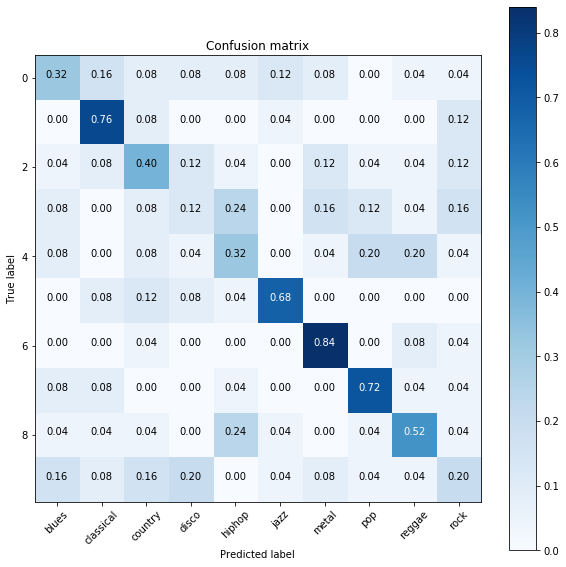

In [84]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genres))
    plt.xticks(tick_marks, genres, rotation=45)
    #plt.yticks(tick_marks, genres)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

### Canciones fuera del dataset

In [85]:
files = os.listdir('./test_songs/images/')
# songs = [ img for img in files if img.split('.')[-1] == 'png']
songs = ['./test_songs/images/'+img for img in files if img.split('.')[-1] == 'png']

for song in songs:
    img = cv2.imread(song,0)
    #img = crop_borders(img)
    #img = crop_borders(img,x1=50,x2=252,y1=144,y2=244)
    #img = extract_features(song)
    mel = img.ravel()
    mel = np.hstack([1, mel])
#     pred = logreg2.predict(mel.reshape(1, -1))
    probabilities = sigmoid(np.matmul(mel.reshape(1,-1), classifiers.T))
    # Nos quedamos con el indice (la clase) que tenga la probabilidad más alta
    pred = np.argmax(probabilities, axis=1)
    print(song)
    print(genres_pred[int(pred)])

./test_songs/images/abba.png
rock
./test_songs/images/abba_BnW.png
rock
./test_songs/images/abba_no_cut.png
pop
./test_songs/images/desakato.png
pop
./test_songs/images/desakato_BnW.png
pop
./test_songs/images/desakato_no_cut.png
metal
./test_songs/images/elfinde.png
pop
./test_songs/images/elfinde_BnW.png
pop
./test_songs/images/elfinde_no_cut.png
pop
./test_songs/images/harder.png
hiphop
./test_songs/images/harder_BnW.png
hiphop
./test_songs/images/iseo.png
pop
./test_songs/images/iseo_BnW.png
pop
./test_songs/images/iseo_no_cut.png
metal
./test_songs/images/marley.png
pop
./test_songs/images/marley_BnW.png
pop
./test_songs/images/marley_no_cut.png
pop
./test_songs/images/metallica.png
metal
./test_songs/images/metallica_BnW.png
metal
./test_songs/images/metallica_no_cut.png
metal
./test_songs/images/paradise.png
pop
./test_songs/images/paradise_BnW.png
pop
./test_songs/images/paradise_no_cut.png
pop
./test_songs/images/requiem.png
classical
./test_songs/images/requiem_BnW.png
classi

## Sklearn

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [88]:
from sklearn.linear_model import LogisticRegression
logreg2=LogisticRegression(C=0.001,penalty="l2",max_iter=10000,multi_class = "multinomial", solver = "lbfgs")
logreg2.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
preds = logreg2.predict(X_test)
# preds

In [90]:
print("Numero de test: ", len(y_test))
fallos =  np.where([preds != y_test])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([preds == y_test])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(preds == y_test)
print("Porcentaje de aciertos: ", accuracy)

Numero de test:  250
Numero de fallos: 132
Numero de aciertos: 118
Porcentaje de aciertos:  47.199999999999996


In [91]:
genres_pred = {}
for k,v in genres.items():
    genres_pred[v] = k
print("Muestreo de fallos\n")
sample = fallos[np.random.choice(fallos.shape[0], 10)]
for a in sample:
    print(genres_pred[preds[a]],"::" ,genres_pred[y_test[a]])

Muestreo de fallos

country :: hiphop
pop :: metal
disco :: country
metal :: country
disco :: reggae
reggae :: country
pop :: classical
reggae :: hiphop
jazz :: blues
hiphop :: jazz


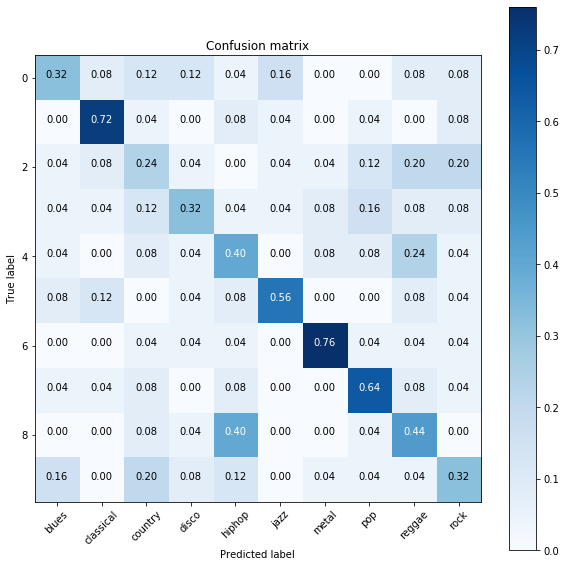

In [92]:
cm2 = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm2, classes, normalize=True)

### Canciones fuera del dataset usando sklearn

In [93]:
files = os.listdir('./test_songs/images/')
# songs = [ img for img in files if img.split('.')[-1] == 'png']
songs = ['./test_songs/images/'+img for img in files if img.split('.')[-1] == 'png']
songs

['./test_songs/images/abba.png',
 './test_songs/images/abba_BnW.png',
 './test_songs/images/abba_no_cut.png',
 './test_songs/images/desakato.png',
 './test_songs/images/desakato_BnW.png',
 './test_songs/images/desakato_no_cut.png',
 './test_songs/images/elfinde.png',
 './test_songs/images/elfinde_BnW.png',
 './test_songs/images/elfinde_no_cut.png',
 './test_songs/images/harder.png',
 './test_songs/images/harder_BnW.png',
 './test_songs/images/iseo.png',
 './test_songs/images/iseo_BnW.png',
 './test_songs/images/iseo_no_cut.png',
 './test_songs/images/marley.png',
 './test_songs/images/marley_BnW.png',
 './test_songs/images/marley_no_cut.png',
 './test_songs/images/metallica.png',
 './test_songs/images/metallica_BnW.png',
 './test_songs/images/metallica_no_cut.png',
 './test_songs/images/paradise.png',
 './test_songs/images/paradise_BnW.png',
 './test_songs/images/paradise_no_cut.png',
 './test_songs/images/requiem.png',
 './test_songs/images/requiem_BnW.png',
 './test_songs/images/requ

In [94]:
for song in songs:
    img = cv2.imread(song,0)
    #img = crop_borders(img)
    #img = crop_borders(img,x1=50,x2=252,y1=144,y2=244)
    #img = extract_features(song)
    mel = img.ravel()
    mel = np.hstack([1, mel])
    pred = logreg2.predict(mel.reshape(1, -1))
    print(song, "-->" ,genres_pred[int(pred)])

./test_songs/images/abba.png --> rock
./test_songs/images/abba_BnW.png --> rock
./test_songs/images/abba_no_cut.png --> metal
./test_songs/images/desakato.png --> pop
./test_songs/images/desakato_BnW.png --> pop
./test_songs/images/desakato_no_cut.png --> metal
./test_songs/images/elfinde.png --> pop
./test_songs/images/elfinde_BnW.png --> pop
./test_songs/images/elfinde_no_cut.png --> pop
./test_songs/images/harder.png --> hiphop
./test_songs/images/harder_BnW.png --> hiphop
./test_songs/images/iseo.png --> hiphop
./test_songs/images/iseo_BnW.png --> hiphop
./test_songs/images/iseo_no_cut.png --> metal
./test_songs/images/marley.png --> pop
./test_songs/images/marley_BnW.png --> pop
./test_songs/images/marley_no_cut.png --> pop
./test_songs/images/metallica.png --> metal
./test_songs/images/metallica_BnW.png --> metal
./test_songs/images/metallica_no_cut.png --> metal
./test_songs/images/paradise.png --> hiphop
./test_songs/images/paradise_BnW.png --> hiphop
./test_songs/images/paradi

### Usando features del csv

In [143]:
df = pd.read_csv('./data/features_30_sec.csv')

In [144]:
df.loc[df['filename'] == 'jazz.00054.wav'] #Corrupted

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
554,jazz.00054.wav,662112,0.27827,0.083737,0.162394,0.002747,1670.233117,255560.9662,2109.438546,191916.069574,...,44.333191,-5.273277,56.501907,-1.605975,60.76976,-2.93224,52.397224,-1.418922,100.980064,jazz


In [145]:
df1 = df.iloc[:, 1:-1]
features30sec = df1.to_numpy()
features30sec = np.delete(features30sec, 554, axis=0)

In [146]:
print(features30sec.shape) #Solo 58 features por cancion -> pocas

(999, 58)


In [147]:
#como 58 son pocas features necesitamos obtener más (metodo explicado en generador de datos)
df_features = pd.read_csv('./data/gtzan_features.csv')

#### Usando codigo de practicas

In [148]:
X_csv = df_features.drop(['genre'], axis=1).values
y_csv = df_features['genre'].values

In [149]:
num_examples = np.shape(X_csv)[0] #999 imagenes
num_features = np.shape(X_csv)[1] #72695 atributos por cada imagen
num_etiquetas = 10 # hay 10 generos

# añadimos una columna de 1's a la X
X_csv = np.hstack([np.ones([num_examples, 1]), X_csv])
X_csv.shape
# y_csv.shape

(999, 134)

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_csv, y_csv, stratify=y)

regul_param = 0.1
classifiers = oneVsAll(X_train, y_train, num_etiquetas, regul_param)

In [151]:
probabilities = sigmoid(np.matmul(X_test, classifiers.T))
# Nos quedamos con el indice (la clase) que tenga la probabilidad más alta
predictions = np.argmax(probabilities, axis=1)

In [152]:
print("Numero de test: ", len(y_test))
fallos =  np.where([predictions != y_test])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y_test])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y_test)
print("Porcentaje de aciertos: ", accuracy)

Numero de test:  250
Numero de fallos: 72
Numero de aciertos: 178
Porcentaje de aciertos:  71.2


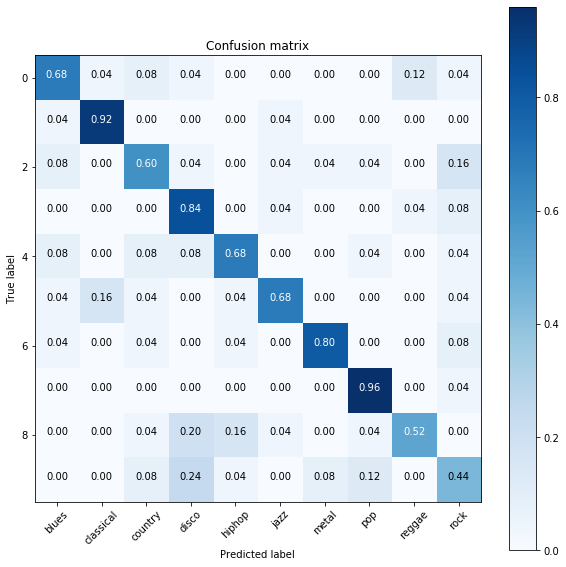

In [154]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

#### Sklearn

In [157]:
X_csv = df_features.drop(['genre'], axis=1).values
y_csv = df_features['genre'].values

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X_csv, y_csv, stratify=y_csv)

In [170]:
%%time
from sklearn.linear_model import LogisticRegression
logreg2=LogisticRegression(C=.001,penalty="l2",max_iter=10000,multi_class = "multinomial", solver = "lbfgs")
logreg2.fit(X_train,y_train)

Wall time: 5.28 s


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [171]:
preds = logreg2.predict(X_test)

In [172]:
print("Numero de test: ", len(y_test))
fallos =  np.where([preds != y_test])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([preds == y_test])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(preds == y_test)
print("Porcentaje de aciertos: ", accuracy)

Numero de test:  250
Numero de fallos: 71
Numero de aciertos: 179
Porcentaje de aciertos:  71.6


In [173]:
genres_pred = {}
for k,v in genres.items():
    genres_pred[v] = k
print("Muestreo de fallos\n")
sample = fallos[np.random.choice(fallos.shape[0], 10)]
for a in sample:
    print(genres_pred[preds[a]],"::" ,genres_pred[y_test[a]])

Muestreo de fallos

rock :: disco
blues :: country
disco :: rock
hiphop :: disco
classical :: jazz
hiphop :: rock
rock :: country
rock :: disco
classical :: jazz
classical :: hiphop


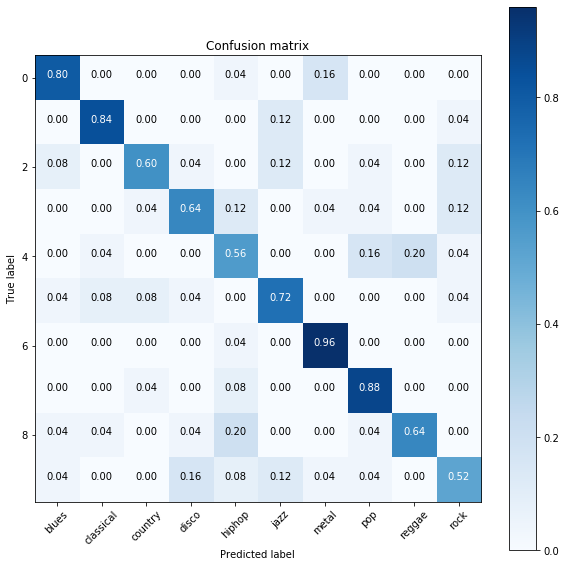

In [174]:
cm2 = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm2, classes, normalize=True)

#### Canciones fuera del dataset

In [175]:
#Funcion para obtener 133 features de una signal de audio
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                print(file)
                if(file != "jazz.00054.wav"): #archivo corrupto
                    file_name = folder + "/" + file
                    signal, sr = librosa.load(file_name)

                    # Debug process
                    if debug:
                        print("Reading file: {}".format(file_name))

                    # Append the result to the data structure
                    features = get_features(signal, sr)
                    features['genre'] = genres[x]
                    arr_features.append(features)
    return arr_features

In [176]:
arr_features = []

# Read files from the folders
folder = './test_songs/'
files = os.listdir(folder)
files = ['./test_songs/'+img for img in files if img.split('.')[-1] == 'mp3']
for file in files:
    # Read the audio file
    signal, sr = librosa.load(file, duration=30.0)
    print("Reading file: {}".format(file))
    # Append the result to the data structure
    features = get_features(signal, sr)
    arr_features.append(features)

gtzan_dir = './test_songs'
df_features = pd.DataFrame(arr_features)

C:\Users\Alberto\Anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Reading file: ./test_songs/abba.mp3
Reading file: ./test_songs/desakato.mp3
Reading file: ./test_songs/elfinde.mp3
Reading file: ./test_songs/harder.mp3
Reading file: ./test_songs/iseo.mp3
Reading file: ./test_songs/marley.mp3
Reading file: ./test_songs/metallica.mp3
Reading file: ./test_songs/paradise.mp3
Reading file: ./test_songs/requiem.mp3
Reading file: ./test_songs/sultans.mp3
Reading file: ./test_songs/wutang.mp3


In [177]:
X_pruebas = df_features
preds = logreg2.predict(X_pruebas)

In [178]:
i = 0
for pred in preds:
    print(songs[i][20:-4],"-->",genres_pred[int(pred)],'\n')
    i += 1

abba --> classical 

abba_BnW --> classical 

abba_no_cut --> classical 

desakato --> classical 

desakato_BnW --> hiphop 

desakato_no_cut --> classical 

elfinde --> metal 

elfinde_BnW --> classical 

elfinde_no_cut --> classical 

harder --> hiphop 

harder_BnW --> hiphop 



In [179]:
#hay sobreajuste a classical
